In [ ]:
FROMYEAR = 2022
TOYEAR = 2025
str_qr = F"""
with data_base AS (

SELECT

FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
toneladas_facturadas AS Toneladas_Facturas
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE EXTRACT(YEAR FROM fecha) >= {FROMYEAR} # Este es el que vamos a usar en productivo
AND nom_gerencia NOT IN ('ACERIAS SPOT')

)

# Agregar un cambio de valores para los cuales Toneladas_Facturas es 0 si el valor original es negativo

SELECT 
MesAnio,NombreGrupo,NombreDireccion,
NombreSubdireccion,NombreGrupoEstadistico1,
NombreGrupoEstadistico2,NombreGrupoEstadistico3,
CASE 
  WHEN Toneladas_Facturadas IS NULL THEN -1
  WHEN Toneladas_Facturadas < 0 THEN 0
  WHEN Toneladas_Facturadas >= 0 THEN Toneladas_Facturadas
END Toneladas_Facturadas
FROM
(
SELECT 
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3,
SUM(data_base.Toneladas_Facturas) AS Toneladas_Facturadas
FROM data_base
WHERE 
-- Descartamos los siguientes campos
NombreGrupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND
NombreDireccion NOT IN ('EXPORTACIÓN ALAMBRES')
AND
NombreSubdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
AND
NombreGrupoEstadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
AND
NombreGrupoEstadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
AND
NombreGrupoEstadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND MesAnio IS NOT NULL
AND NombreGrupo IS NOT NULL
AND NombreDireccion IS NOT NULL
AND NombreSubdireccion IS NOT NULL
AND NombreGrupoEstadistico1 IS NOT NULL
AND NombreGrupoEstadistico2 IS NOT NULL
AND NombreGrupoEstadistico3 IS NOT NULL
GROUP BY
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3
)
WHERE MesAnio < '2025-09-01'   
ORDER BY MesAnio ASC, Toneladas_Facturadas DESC
"""

def load_pv(query_str):

    client = bigquery.Client(project="demanda-prj-dev")

    consulta = query_str

    query = client.query(consulta)

    pv = query.to_dataframe(create_bqstorage_client=True)

    pv.rename(columns = {"Toneladas_Facturadas":"Toneladas Facturadas"}, inplace = True)

    pv["Toneladas Facturadas"] =  pv["Toneladas Facturadas"].astype(float)

    pv.to_excel(r".\outputs\HISTORICO_FACTURACION.xlsx", sheet_name="SUB-GE3 historico", index = False)
    
    return pv

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

#--------------------------------FUNCIONES--------------------------------#

def transform_MIDAS(df, pv, join_pv = False):
    # --- Define columns to extract ---
    colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"]

    # --- First Filter: Y_PREDICCION --- Filtro de valores nulos? por que habria valores nulos? 
    df1 = df[colNames] #df["Y_PREDICCION"].notna()]

    # --- Second Filter: Y_PRONOSTICOS --- Filtro de valores nulos? por que habria valores nulos?
    df2 = df[colNames2] #f["Y_PRONOSTICOS"].notna()

    df2.columns = colNames  # Rename to match df1

    df3 = df[df.MODEL == "BayesianRidge"][colNames3]
    #df3 ["MODEL"] = "Y_HIST"
    df3["Y_HIST"] = df3["Y_HIST"].astype(float)
    #df3 = df3.groupby(["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"])[["Y_HIST"]]
    
    # --- Combine both filtered datasets ---
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # --- Reorder columns: move Y_PREDICCION next to MODEL ---
    cols = combined_df.columns.tolist()

    y_pred_idx = cols.index("Y_PREDICCION")

    model_idx = cols.index("MODEL")

    cols.insert(model_idx + 1, cols.pop(y_pred_idx))

    combined_df = combined_df[cols]

    combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

    

    #display(combined_df.FECHA.value_counts().sort_index())
    res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

    res["MAX_MODEL"] = True

    res = res.merge(df3, on = ["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], how = "outer", validate = "1:1")

    res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

    res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)
    
    res["FECHA"] = pd.to_datetime(res["FECHA"])
    
    if join_pv == True:

        out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")
        
        out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)
        
        return out
    else:

        return res
    

def load_pv(query_str):

    client = bigquery.Client(project="demanda-prj-dev")

    consulta = query_str

    query = client.query(consulta)

    pv = query.to_dataframe(create_bqstorage_client=True)

    pv.sort_index(inplace=True, ascending=True)

    pv["PVO"] = pv["PVO"].astype(float)

    pv["PV"] = pv["PV"].astype(float)

    pv["FACT"] = pv["FACT"].astype(float).fillna(0)

    #pv["MAX"] = pv["MAX"].astype(float)

    pv["id"] = pv['NombreGrupo'] + "_" + pv['NombreDireccion'] + "_" + pv['NombreSubdireccion'] + "_" + pv['GE1'] + "_" + pv['GE2'] + "_" + pv['GE3']

    # Obtener todos los valores únicos de cada columna clave
    fechas = pv['FECHA'].unique()
    
    id = pv['id'].unique()

    # Generar todas las combinaciones posibles
    combinaciones = pd.DataFrame(list(itertools.product(fechas, id)), columns=['FECHA',"id"])
    for i, col  in enumerate(["NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"]):
        print(i, col)
        combinaciones[col] = combinaciones["id"].str.split("_").apply(lambda x:x[i])

    # Unir con el DataFrame original
    df_completo = pd.merge(combinaciones, pv, on=["FECHA","id","NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"], how='left')

    df_completo["FACT"] = df_completo["FACT"].fillna(np.nan)

    df_completo["valid_ton"] = df_completo.PVO.fillna(0) + df_completo.FACT.fillna(0)

    df_completo["FECHA"] = pd.to_datetime(df_completo["FECHA"])

    pv = df_completo.copy()
    
    return pv

date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-03-01


In [3]:
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS FECHA,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS GE1,
nom_grupo_estadistico2 AS GE2,
nom_grupo_estadistico3 AS GE3,
sum(toneladas_pvo) AS PVO,
sum(toneladas_facturadas) AS FACT,
#sum(toneladas_mejor_pronostico) AS MAX,
sum(toneladas_plan_ventas) AS PV
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2025
AND
EXTRACT(YEAR FROM fecha) < 2026
AND
nom_direccion NOT IN  ('FILIALES') --> lo quité de la consulta duplica SUBDIRG3
AND
nom_subdireccion NOT IN  ('SERVICIOS LOGISTICOS DAL USA') --> lo quité de la consulta duplica SUBDIRG3
-- Descartamos los siguientes campos
#AND
#nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
#AND
#nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

pv = load_pv(str_qr)

#display(pv.FECHA.value_counts())

pv.sample(5)

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


KeyError: 'PVO'

In [43]:
ls "../../bd/Facturacion BQ/MIDAS/PRONOSTICO 2025"

 El volumen de la unidad C es Windows 
 El n�mero de serie del volumen es: FC47-8A0A

 Directorio de c:\Users\adojeda\OneDrive - deacero.com\bd\Facturacion BQ\MIDAS\PRONOSTICO 2025

10/09/2025  08:06 a. m.    <DIR>          .
10/09/2025  08:04 a. m.    <DIR>          ..
10/09/2025  08:03 a. m.        52,158,084 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_053556.csv
10/09/2025  08:04 a. m.        52,261,891 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_061206.csv
10/09/2025  08:04 a. m.        52,221,489 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_060135.csv
10/09/2025  08:04 a. m.        52,140,760 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_054444.csv
10/09/2025  08:03 a. m.        52,193,128 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_050240.csv
10/09/2025  08:04 a. m.        52,057,818 o

In [44]:
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/PRONOSTICO 2025"

list_df = []
for path in  os.listdir(LIST_DIR):
    print(path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df

base = pd.concat(list_df)

del list_df

base_t = transform_MIDAS(base, pv, join_pv= True)


outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_053556.csv
outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_061206.csv
outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_060135.csv
outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_054444.csv
outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_050240.csv
outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_055310.csv
outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_052653.csv
outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250910_051814.csv


KeyError: 'Y_HIST'

In [77]:
base_t = transform_MIDAS(base, pv, join_pv= True)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2351720421.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)
C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2351720421.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)


In [79]:
base_t.groupby(["MAX_MODEL","FECHA"])[["Y_HIST", "FACT"]].sum()

Y_HIST           FACT
MAX_MODEL FECHA                                   
False     2024-01-01       0.000000  284768.855967
          2024-02-01  172147.118499  215827.739102
          2024-03-01  154587.363598  191878.548756
          2024-04-01  210876.896689  257486.535253
          2024-05-01  190568.669003  228823.604472
          2024-06-01  181758.641304  219955.627657
          2024-07-01  161068.173640  207756.659842
          2024-08-01       0.000000   54196.607447
          2024-09-01       0.000000   41300.917117
          2024-10-01       0.000000   42233.417405
          2024-11-01       0.000000   43773.268979
          2024-12-01       0.000000   42353.587506
          2025-01-01       0.000000   46565.693786
          2025-02-01       0.000000   37278.258865
          2025-03-01       0.000000   46595.784478
          2025-04-01       0.000000   45765.140938
          2025-05-01       0.000000   51681.864565
          2025-06-01       0.000000   52477.324486
          2025-07-01       0.000000   50742.772596
          2025-08-01       0.000000   64198.541034
          2025-09-01       0.000000   14308.867493
          2025-10-01       0.000000       0.000000
          2025-11-01       0.000000       0.000000
          2025-12-01       0.000000       0.000000
True      2024-08-01  163178.137983  162954.104163
          2024-09-01  154745.668081  154280.532521
          2024-10-01  164622.905311  164625.867791
          2024-11-01  165297.966330  165225.717800
          2024-12-01  141375.308724  148920.438264
          2025-01-01  192318.675587  191811.167767
          2025-02-01       0.000000  174242.624133
          2025-03-01       0.000000  178587.916715
          2025-04-01       0.000000  164994.846718
          2025-05-01       0.000000  165643.480139
          2025-06-01       0.000000  146428.269879
          2025-07-01       0.000000  170460.695735
          2025-08-01       0.000000  169286.699587
          2025-09-01       0.000000   42760.043274

In [69]:
#base.groupby("FECHA")[].isna()
base.groupby(["FECHA", "MODEL"])[['Y_HIST', 'Y_TEST', 'Y_PREDICCION', 'Y_PRONOSTICOS']].sum().round(0).unstack(-1)

Y_HIST                                                \
MODEL      BayesianRidge GradientBoostingRegressor KNeighborsRegressor   
FECHA                                                                    
2024-02-01      177969.0                  177969.0            177969.0   
2024-03-01      163598.0                  163598.0            163598.0   
2024-04-01      216151.0                  216151.0            216151.0   
2024-05-01      199309.0                  199309.0            199309.0   
2024-06-01      188141.0                  188141.0            188141.0   
2024-07-01      170761.0                  170761.0            170761.0   
2024-08-01      173276.0                  173276.0            173276.0   
2024-09-01      160864.0                  160864.0            160864.0   
2024-10-01      173719.0                  173719.0            173719.0   
2024-11-01      170421.0                  170421.0            170421.0   
2024-12-01      148476.0                  148476.0            148476.0   
2025-01-01      197934.0                  197934.0            197934.0   
2025-02-01           0.0                       0.0                 0.0   
2025-03-01           0.0                       0.0                 0.0   
2025-04-01           0.0                       0.0                 0.0   
2025-05-01           0.0                       0.0                 0.0   
2025-06-01           0.0                       0.0                 0.0   
2025-07-01           0.0                       0.0                 0.0   
2025-08-01           0.0                       0.0                 0.0   
2025-09-01           0.0                       0.0                 0.0   

                                                                    \
MODEL      LGBMRegressor RandomForestRegressor     Ridge       SVR   
FECHA                                                                
2024-02-01      177969.0              177969.0  177969.0  177969.0   
2024-03-01      163598.0              163598.0  163598.0  163598.0   
2024-04-01      216151.0              216151.0  216151.0  216151.0   
2024-05-01      199309.0              199309.0  199309.0  199309.0   
2024-06-01      188141.0              188141.0  188141.0  188141.0   
2024-07-01      170761.0              170761.0  170761.0  170761.0   
2024-08-01      173276.0              173276.0  173276.0  173276.0   
2024-09-01      160864.0              160864.0  160864.0  160864.0   
2024-10-01      173719.0              173719.0  173719.0  173719.0   
2024-11-01      170421.0              170421.0  170421.0  170421.0   
2024-12-01      148476.0              148476.0  148476.0  148476.0   
2025-01-01      197934.0              197934.0  197934.0  197934.0   
2025-02-01           0.0                   0.0       0.0       0.0   
2025-03-01           0.0                   0.0       0.0       0.0   
2025-04-01           0.0                   0.0       0.0       0.0   
2025-05-01           0.0                   0.0       0.0       0.0   
2025-06-01           0.0                   0.0       0.0       0.0   
2025-07-01           0.0                   0.0       0.0       0.0   
2025-08-01           0.0                   0.0       0.0       0.0   
2025-09-01           0.0                   0.0       0.0       0.0   

                               Y_TEST                            \
MODEL      XGBRegressor BayesianRidge GradientBoostingRegressor   
FECHA                                                             
2024-02-01     177969.0           0.0                       0.0   
2024-03-01     163598.0           0.0                       0.0   
2024-04-01     216151.0           0.0                       0.0   
2024-05-01     199309.0           0.0                       0.0   
2024-06-01     188141.0           0.0                       0.0   
2024-07-01     170761.0           0.0                       0.0   
2024-08-01     173276.0      173276.0                  173276.0   
2024-09-01     160864.0      16086

In [165]:
def process_pop(df):

    df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

    df.FECHA = pd.to_datetime(df.FECHA)

    #FILTRO LIMITE INFERIOR
    df = df [df.FECHA >= "2024-01-01"]

    #FILTRO LIMITE SUPERIOR?

    #df = df [df.FECHA <= date_forecas]

    df['Segmento'] = np.where ((df.FECHA >= "2024-01-01") & (df.FECHA <= "2025-01-01"), "Validacion", "Pronostico")

    # Agregando modelo WOC
    df['WOC'] = df[["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor"]].mean(numeric_only = True, axis = 1)

    cols2mape = ["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC"]
    
    df['FACT'] = df['FACT'].fillna(0)

    # FUNCION MAPE DEACERO
    def asignar_valor(df, col1, col2):
        try: 
            if df[col1] < 1 and df[col2] < 1:      
                return 0
            elif df[col1] >= 1 and df[col2] < 1:      
                return 1
            elif df[col1] < 1 and df[col2] >= 1:
                return 1
            else:
                return abs(df[col1] - df[col2]) / df[col2]
        except:
            return None

    # FUNCION promedio mape
    def kashyyyk(x):
        return x.mean()

    # calculamos mape
    print("calulamos mape ----------------------------------------------")
    for col in cols2mape:
        print(col)
        df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

    # agrupamos para calculo de avg mape
    tattoine = df.groupby(['SUBG3', 'Segmento'])

    print("calulamos avg_mape a grupo -----------------------")
    # iteramos sobre calculo avg mape
    for col in cols2mape:
        print(col)

        df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
        
        # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
        #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

        # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
        df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')

    avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

    # Seleccionando menor MAPE
    df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

    kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

    df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

    # eliminamos palabra AVG_MAPE_
    df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

    anakin = df.melt('MAX_Modelo', ignore_index = False)

    df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

    def desviacion(df, col1, col2):
        try: 
            if df[col1] <= 0.1 and df[col2] <= 0.1:
                return 0
            elif df[col1] <= 0.1 and df[col2] > 0.1:
                return 1
            elif df[col1] > 0.1 and df[col2] <= 0.1:
                return 1
            else:
                return df[col1]/df[col2]
        except: 
            return None

    df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

    # CALCULAMOS ESTATUS DE STD 
    def estatus(df, col):
        if df[col] > 0.5:
            val = 'Desviacion alta'
        else:
            val = 'Desviacion baja'
        return val

    df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

    df["MEJOR_MODELO_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = "MAX_Valores", axis = 1)

    df.head()
    
    return df


out = process_pop(base_t[base_t.MAX_MODEL == True])

C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2955714888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]
C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2955714888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.FECHA = pd.to_datetime(df.FECHA)


calulamos mape ----------------------------------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


(0.0, 1.2)

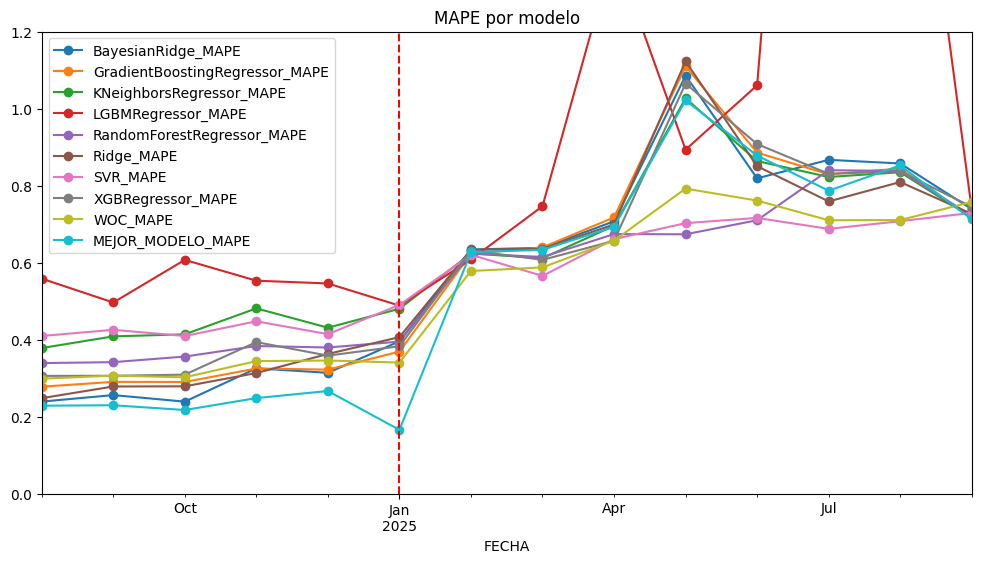

In [167]:
MAPE_COLS = out.loc[:, out.columns.str.contains("_MAPE") & ~out.columns.str.contains("AVG_MAPE|Min_")].columns

ax = out.groupby("FECHA")[MAPE_COLS].mean().plot(figsize = (12,6), marker = 'o', title = "MAPE por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')

ax.set_ylim(0, 1.2)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2188664257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]
C:\Users\adojeda\AppData\Local\Temp\ipykernel_22256\2188664257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.FECHA = pd.to_datetime(df.FECHA)


calulamos mape ----------------------------------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


(0.2, 1.2)

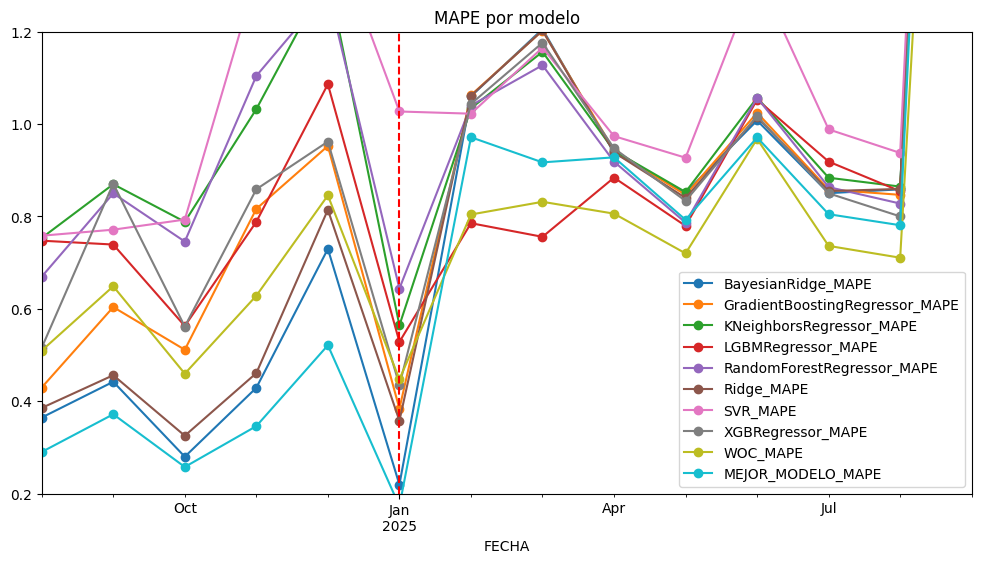

In [172]:
def process_pop(df):

    df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

    df.FECHA = pd.to_datetime(df.FECHA)

    #FILTRO LIMITE INFERIOR
    df = df [df.FECHA >= "2024-01-01"]

    #FILTRO LIMITE SUPERIOR?

    #df = df [df.FECHA <= date_forecas]

    df['Segmento'] = np.where ((df.FECHA >= "2024-01-01") & (df.FECHA <= "2025-01-01"), "Validacion", "Pronostico")

    # Agregando modelo WOC
    df['WOC'] = df.mean(numeric_only = True, axis = 1)

    cols2mape = ["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC"]

    # FUNCION MAPE DEACERO
    def asignar_valor(df, col1, col2):
        try: 
            if df[col1] < 1 and df[col2] < 1:
                return 0
            elif df[col1] >= 1 and df[col2] < 1:      
                return 1
            elif df[col1] < 1 and df[col2] >= 1:
                return 1
            else:
                return abs(df[col1] - df[col2]) / df[col1]
        except:
            return None

    # FUNCION promedio mape
    def kashyyyk(x):
        return x.mean()

    # calculamos mape
    print("calulamos mape ----------------------------------------------")
    for col in cols2mape:
        print(col)
        df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

    # agrupamos para calculo de avg mape
    tattoine = df.groupby(['SUBG3', 'Segmento'])

    print("calulamos avg_mape a grupo -----------------------")
    # iteramos sobre calculo avg mape
    for col in cols2mape:
        print(col)

        df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
        
        # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
        #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

        # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
        df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')

    avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

    # Seleccionando menor MAPE
    df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

    kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

    df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

    # eliminamos palabra AVG_MAPE_
    df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

    anakin = df.melt('MAX_Modelo', ignore_index = False)

    df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

    def desviacion(df, col1, col2):
        try: 
            if df[col1] <= 0.1 and df[col2] <= 0.1:
                return 0
            elif df[col1] <= 0.1 and df[col2] > 0.1:
                return 1
            elif df[col1] > 0.1 and df[col2] <= 0.1:
                return 1
            else:
                return df[col1]/df[col2]
        except: 
            return None

    df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

    # CALCULAMOS ESTATUS DE STD 
    def estatus(df, col):
        if df[col] > 0.5:
            val = 'Desviacion alta'
        else:
            val = 'Desviacion baja'
        return val

    df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

    df["MEJOR_MODELO_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = "MAX_Valores", axis = 1)

    df.head()
    
    return df


out = process_pop(base_t[base_t.MAX_MODEL == True])

MAPE_COLS = out.loc[:, out.columns.str.contains("_MAPE") & ~out.columns.str.contains("AVG_MAPE|Min_")].columns

ax = out.groupby("FECHA")[MAPE_COLS].mean().plot(figsize = (12,6), marker = 'o', title = "MAPE por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')


ax.set_ylim(0.2, 1.2)


(140000.0, 200000.0)

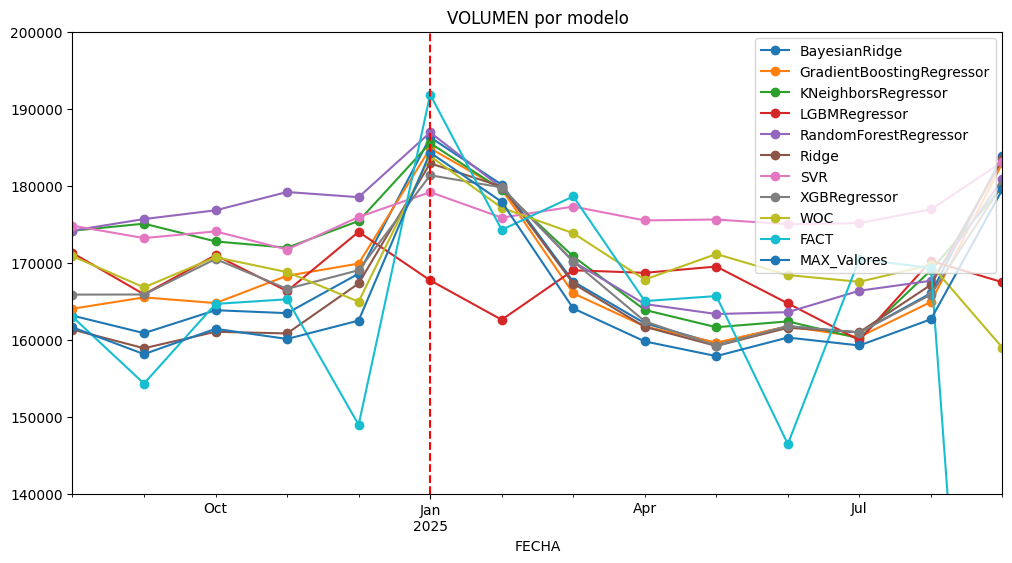

In [174]:
cols2mape = [ "BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC", "FACT", "MAX_Valores"]

ax = out.groupby("FECHA")[cols2mape].sum().plot(figsize = (12,6), marker = 'o', title = "VOLUMEN por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')

ax.set_ylim(140000, 200000)

(160000.0, 200000.0)

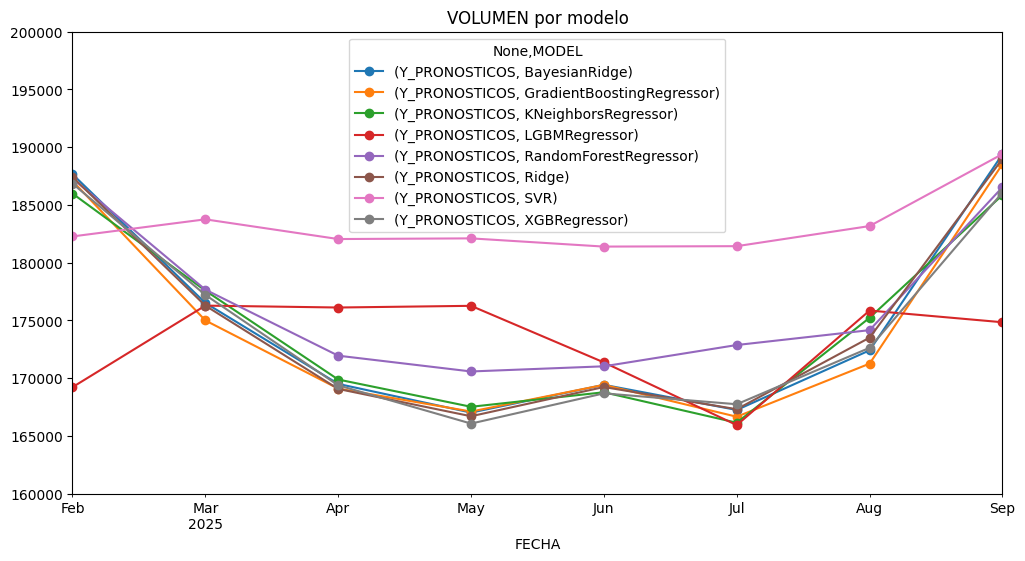

In [175]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].sum().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "VOLUMEN por modelo")
ax.set_ylim(160000, 200000)

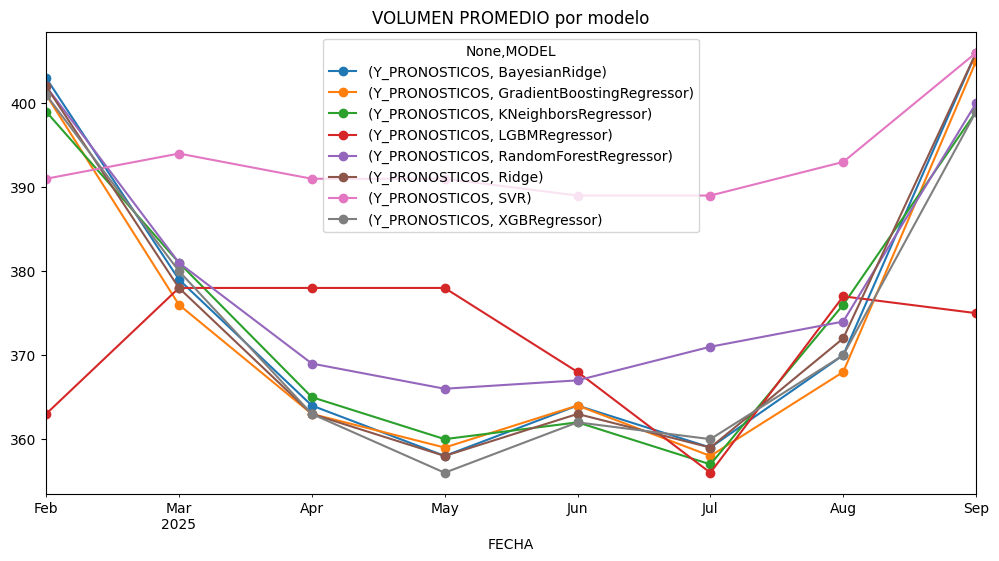

In [151]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].mean().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "VOLUMEN PROMEDIO por modelo")
#ax.set_ylim(160000, 200000)

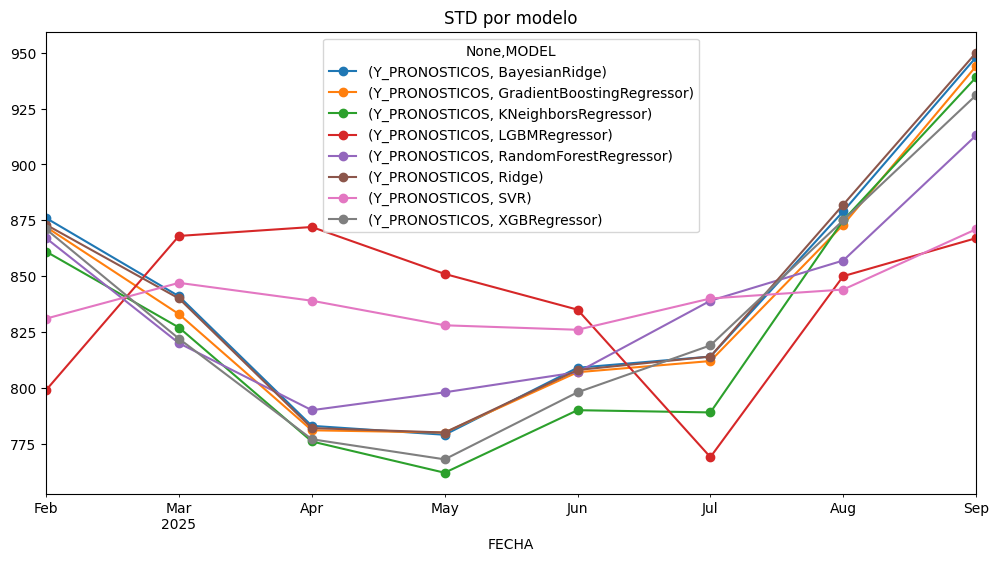

In [152]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].std().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "STD por modelo")
#ax.set_ylim(160000, 200000)